![ToOL-PRO-BES.png](Info/ToOL-PRO-BES.png)

## Import packages

In [70]:
import pandas as pd
from tqdm.autonotebook import trange, tqdm

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import datetime
from datetime import datetime, timedelta, timezone
from pytz import timezone

import os
import re

import dash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import time
import numpy as np
import math
import seaborn as sns

import requests
import io
import warnings

## Setup from Info.xlsx

In [71]:
info = pd.read_excel("Info/Info.xlsx", sheet_name=None, index_col=0)
print(*info.keys(), sep = " | ")

setup | datasets | charts | plots | parameters | parameters_ave | colours


## Functions

In [72]:
# Date Functions
def set_date(date_str, old_tz, dt_format = "%d/%m/%Y %H:%M:%S"):
    if date_str == 'NaT':
        return pd.NaT
    else:
        datetime_set_naive = datetime.strptime(date_str, dt_format)
        datetime_set_old = timezone(old_tz).localize(datetime_set_naive)
        datetime_set_utc = datetime_set_old.astimezone(timezone('UTC'))
        return datetime_set_utc

def date_parser(date_, time_, dt_format = "%d/%m/%Y %H:%M:%S"):
    return set_date(date_ + " " + time_, 'UTC', dt_format)

def date_parserYMD(date_, time_, dt_format = "%Y-%m-%d %H:%M:%S"):
    return set_date(date_ + " " + time_, 'UTC', dt_format)


# Experiment start/end date
date_start = set_date(str(info['setup'].loc['date_start_utc','value']), "UTC", "%Y-%m-%d %H:%M:%S")
if pd.isna(info['setup'].loc['date_end_utc','value']):
    date_now = datetime.now(timezone('UTC'))
    info['setup'].loc['date_end_utc','value'] = date_now
else:
    date_now = set_date(str(info['setup'].loc['date_end_utc','value']), "UTC", "%Y-%m-%d %H:%M:%S")

# Date Functions continued
def date_range(window=-1, start=date_start, end=date_now):
    if pd.isna(start):
        start = date_start
    if pd.isna(end):
        end = date_now
    if window != -1:
        if not pd.isna(window):
            start = end - timedelta(days=window)
    return start, end

info['setup']

,value
id,
project,ToOLTuBES v2
date_start_utc,2019-06-04 13:03:17
date_end_utc,2020-02-17 14:08:22.301731+00:00


## Process Information sheets from Info.xlsx

### Datasets:

In [73]:
info['datasets']

,folder,selection,melt,data_folder_path,supp_data_filepath,file_pat,skiprows,Slim,Del_unit_rows,Add_blank_rows
dataset,,,,,,,,,,
UO,1,UO.wide,UO.wide,C:/Users/Martin/Google Drive/ToOLTuBES/LAB/Dat...,C:/Users/Martin/Google Drive/ToOLTuBES/LAB/Dat...,.csv,0,1.0,NaN,1.0
NWL,1,NWL,NWL,C:/Users/Martin/Google Drive/ToOLTuBES/LAB/Dat...,NaN,.xlsx,2,NaN,1.0,NaN
Skid,1,Skid,Skid.ave,C:/Users/Martin/Google Drive/BEWISE_shared/Ski...,NaN,.CSV,2,NaN,NaN,1.0
Skid,2,Skid,Skid.ave,C:/Users/Martin/Google Drive/BEWISE_shared/Ski...,NaN,.CSV,3,NaN,NaN,1.0
SampLog,1,SampLog.wide,SampLog.wide.ave,C:/Users/Martin/Google Drive/BEWISE_shared/Sam...,NaN,.csv,0,1.0,NaN,NaN
Sensor,1,SENSOR,SENSOR,C:/Users/Martin/Google Drive/ToOLTuBESv2/LAB/T...,NaN,\d\d_\d\d_\d\d\d\d\.csv,0,NaN,NaN,NaN
Events,1,EV.wide,EV.ave,C:/Users/Martin/Google Drive/ToOLTuBESv2/LAB/T...,C:/Users/Martin/Google Drive/ToOLTuBESv2/LAB/T...,.csv,0,NaN,NaN,NaN


### Chartxs:

In [74]:
charts = []
for chart, row in info['charts'].iterrows():
    chart_range = date_range(window = row['chart_range_window'], start = set_date(str(row['chart_range_start']), "UTC", "%Y-%m-%d %H:%M:%S"), end = set_date(str(row['chart_range_end']), "UTC", "%Y-%m-%d %H:%M:%S"))
    info['charts'].loc[chart, 'chart_range_start'] = chart_range[0]
    info['charts'].loc[chart, 'chart_range_end'] = chart_range[1]
    info['charts'].loc[chart, 'chart_range_window'] = chart_range[1] - chart_range[0]
    charts.append(chart)

del chart, chart_range, row

info['charts']

,chart,chart_status,chart_res,chart_range_window,chart_range_start,chart_range_end,chart_label
order,,,,,,,
0,high,ON,0,"3 days, 0:00:00",2020-02-14 14:08:22.301731+00:00,2020-02-17 14:08:22.301731+00:00,High Resolution
1,med,ON,5,"14 days, 0:00:00",2020-02-03 14:08:22.301731+00:00,2020-02-17 14:08:22.301731+00:00,Medium Resolution
2,low,ON,120,"258 days, 1:05:05.301731",2019-06-04 13:03:17+00:00,2020-02-17 14:08:22.301731+00:00,Low Resolution
3,low_ave,ON,120,"258 days, 1:05:05.301731",2019-06-04 13:03:17+00:00,2020-02-17 14:08:22.301731+00:00,Low Resolution (average)
4,custom1,OFF,0,"1 day, 0:00:00",2019-06-04 13:03:17+00:00,2019-06-05 13:03:17+00:00,Custom Chart


### Parameters:

In [75]:
info['parameters']

,code,parameter,parameter_ave,parameter_lab,plot,line,ribbon,bar,point,colour,fill,shape,line_type,bar_order,show_in_legend,selected_chart_0,selected_chart_1,selected_chart_2,selected_chart_3
dataset,,,,,,,,,,,,,,,,,,,
Sensor,A1 V,BES_A1__V,BES_1__V_ave,BES 1A,BES_VA,1.0,NaN,NaN,NaN,0.0,0.0,NaN,solid,NaN,True,1,1,1,1
Sensor,A2 V,BES_A2__V,BES_2__V_ave,BES 2A,BES_VA,1.0,NaN,NaN,NaN,3.0,3.0,NaN,solid,NaN,True,1,1,1,1
Sensor,A3 V,BES_A3__V,BES_3__V_ave,BES 3A,BES_VA,1.0,NaN,NaN,NaN,5.0,5.0,NaN,solid,NaN,True,1,1,1,1
Sensor,A4 V,BES_A4__V,BES_4__V_ave,BES 4A,BES_VA,1.0,NaN,NaN,NaN,6.0,6.0,NaN,solid,NaN,True,1,1,1,1
Sensor,B1 V,BES_B1__V,BES_1__V_ave,BES 1B,BES_VB,1.0,NaN,NaN,NaN,0.0,0.0,NaN,longdash,NaN,True,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Events,HOSE_B_STATUS,HOSE_B_STATUS_EV,HOSE_B_STATUS_EV,Heated Hose B Status EV,TEMP_EVENT,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0
Events,HOSE_C_STATUS,HOSE_C_STATUS_EV,HOSE_C_STATUS_EV,Heated Hose C Status EV,TEMP_EVENT,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0
Events,TILT_SP,TILT_SP_EV,TILT_SP_EV,Enclosure Tilt Set Point EV,PRESSURE,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,0,0


In [76]:
info['parameters_ave']

,parameter_ave,parameter_lab,plot,line,ribbon,bar,point,colour,fill,shape,line_type,bar_order,show_in_legend,selected_chart_0,selected_chart_1,selected_chart_2,selected_chart_3
dataset,,,,,,,,,,,,,,,,,
Sensor,BES_1__V_ave,BES 1,BES_V,1.0,1.0,NaN,NaN,1,1.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_2__V_ave,BES 2,BES_V,1.0,1.0,NaN,NaN,4,4.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_3__V_ave,BES 3,BES_V,1.0,1.0,NaN,NaN,7,7.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_4__V_ave,BES 4,BES_V,1.0,1.0,NaN,NaN,10,10.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_1__C_ave,BES 1,BES_C,1.0,1.0,NaN,NaN,1,1.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_2__C_ave,BES 2,BES_C,1.0,1.0,NaN,NaN,4,4.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_3__C_ave,BES 3,BES_C,1.0,1.0,NaN,NaN,7,7.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_4__C_ave,BES 4,BES_C,1.0,1.0,NaN,NaN,10,10.0,NaN,solid,NaN,True,0,0,0,1
Sensor,BES_SUM__V_ave,∑ [BESs],BES_V,1.0,1.0,NaN,NaN,14,14.0,NaN,solid,NaN,True,0,0,0,1


### Plots:

In [77]:
info['plots']

,row,col,plot,plot_lab,ylab,ymin,ymax,height,log,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
chart,,,,,,,,,,,,,,,,
0,1,1,BES_CA,BES,Current Density<br>(μA/cm²),0,40,10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,1,BES_CB,BES,Current Density<br>(μA/cm²),0,40,10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3,1,BES_CC,BES,Current Density<br>(μA/cm²),0,40,10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,1,COD,COD,COD<br>(mg/l O₂),0,600,10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5,1,BOD,BOD,BOD₅<br>(mg/l O₂),0,300,10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,11,1,REXT,REXT,R<sub>Ext</sub><br>(Ω),1,51101,8,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,1,OCP,OCP,OCP,0,1,6,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,1,DO,Dissolved Oxygen,Dissolved<br>Oxygen (mg/l),0,8,10,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Colours:

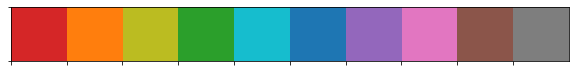

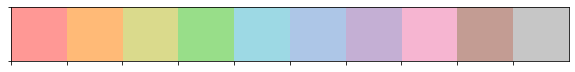

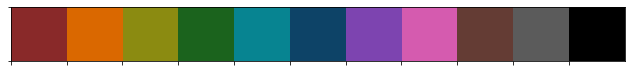

In [78]:
info['colours']

info['colours']['rgb'] = list(zip((info['colours']['r']/255), (info['colours']['g']/255), (info['colours']['b']/255)))
info['colours']['rgb_str'] = "rgb(" + info['colours']['r'].astype(int).astype(str) + "," + info['colours']['g'].astype(int).astype(str) + "," + info['colours']['b'].astype(int).astype(str) + ")"

colour_palettes = {}
colour_palettes['all'] = info['colours']['rgb'].tolist()

for theme in info['colours']['theme'].unique():
    colour_palettes[theme] = info['colours'].query('theme == "' + theme + '"')['rgb'].tolist()
    sns.palplot(colour_palettes[theme])

del theme

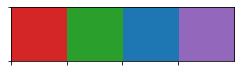

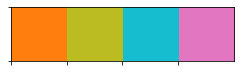

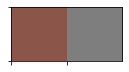

In [79]:
sns.palplot([colour_palettes['mid'][i] for i in [0,3,5,6]])
sns.palplot([colour_palettes['mid'][i] for i in [1,2,4,7]])
sns.palplot([colour_palettes['mid'][i] for i in [8,9]])

del colour_palettes

## Import Data
### Custom Support Data Functions

In [80]:
def get_UO_support_data(dataset_f_info, dataset = "UO"):
    
    def import_UO_log_dates():
        UO_log_dates = pd.read_csv(dataset_f_info['supp_data_filepath'][dataset], sep = "\t")
        UO_log_dates['start'] = pd.to_datetime(UO_log_dates['start'], format="%Y-%m-%d")
        UO_log_dates['end'] = pd.to_datetime(UO_log_dates['end'], format="%Y-%m-%d")
        return UO_log_dates
    
    UO_log_dates = import_UO_log_dates()
    
    #Check LogDates file
    if max(UO_log_dates['end']) < date_now.date() - timedelta(days=1):
        #print("Retrieving latest Urban Observatory data...")
        # api-endpoint 
        URL = "http://uoweb3.ncl.ac.uk/api/v1.1/sensors/data/csv/?"
        # location given here 
        poly = '0103000000010000000600000001000020a2baf9bf58094ee3a2764b4001000020f268fbbf90c059b5b5714b4000000020ba37fbbfc4e78445c6704b4001000020b203fbbf9ce8d60e68714b40010000209a59f9bf346a0efd06714b4001000020a2baf9bf58094ee3a2764b40'
        # defining a params dict for the parameters to be sent to the API 
        PARAMS = {'polygon_wkb': poly,
                  'starttime': max(UO_log_dates['end']).strftime("%Y%m%d%H%M%S"), #"%Y%m%d%H%M%S"
                  'endtime': date_now.strftime("%Y%m%d%H%M%S"), #"%Y%m%d%H%M%S"
                  'data_variable': 'River Level,Temperature,Rainfall'} 
        # sending get request and saving the response as response object 
        data_content = requests.get(url = URL, params = PARAMS).content
        UO_data = pd.read_csv(io.StringIO(data_content.decode("utf-8")))
        min_date = pd.to_datetime(min(UO_data['Timestamp'])).strftime("%Y-%m-%d")
        max_date = pd.to_datetime(max(UO_data['Timestamp'])).strftime("%Y-%m-%d")
        
        if pd.to_datetime(max_date) > max(UO_log_dates['end']):
            UO_data.to_csv(dataset_f_info['data_folder_path'][dataset] + "UO_data_" + str(min_date) + "_to_" + str(max_date) + ".csv",
                           index = False)
            UO_Files = []
            for filename in tqdm(os.listdir(str(dataset_f_info['data_folder_path'][dataset])), desc = "Open existing UO files"):
                if re.search(dataset_f_info['file_pat'][dataset], filename) and not filename.startswith('.'):
                    UO_Files.append(filename)
            UO_starts = []
            for string in UO_Files: UO_starts.append(string[8:18])
            UO_ends = []
            for string in UO_Files: UO_ends.append(string[22:32])


            new_UO_file_data = {'file': UO_Files,
                                'start': UO_starts,
                                'end': UO_ends}
            UO_log_dates_new = pd.DataFrame(new_UO_file_data, columns = ['file', 'start', 'end'])
            UO_log_dates_new.to_csv(dataset_f_info['supp_data_filepath'][dataset], index = False, sep = "\t")
            print("Urban Observatory data updated!")
        else:
            print("Urban Observatory data up-to-date!")
        
    UO_log_dates = import_UO_log_dates
    
    return UO_log_dates

def get_Events_support_data(dataset_f_info, dataset = "Events"):
    Events_info = pd.read_csv(dataset_f_info['supp_data_filepath'][dataset], sep = "\t", index_col = "Code")
    return Events_info

custom_preimport_functions = {'UO': get_UO_support_data,
                              'Events': get_Events_support_data}

### Custom Imported Data Functions

In [81]:
def mod_imported_Sensor_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "Sensor"):
    day_df['DateTime'] = day_df['Date'] + " " + day_df['Time']
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%d/%m/%Y %H:%M:%S')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('UTC')
    
    #Make on/off events integer binary numbers 1/0
    #on_events = ["^ON$", "^RUNNING$", "^CW$", "^AUTO$"]
    #off_events = ["^OFF$", "^STOP$", "^CCW$", "^MANUAL$"]

    #all_rgx = re.compile("|".join(on_events + off_events))
    #on_rgx = re.compile("|".join(on_events))
    #off_rgx = re.compile("|".join(off_events))
    
    #Sensor_events = {'ON': 1,
    #                 'RUNNING': 1,
    #                 'CW': 1,
    #                 'AUTO': 1,
    #                 'OFF': 0,
    #                 'STOP': 0,
    #                 'CCW': 0,
    #                 'MANUAL': 0}

    #string_cols = (day_df.applymap(type) == str).all(0).values
    #for col in day_df.iloc[:, string_cols]:
    #    if day_df[col].str.contains(all_rgx).any():
    #        day_df[col] = day_df[col].replace(on_rgx, '1', regex=True)
    #        day_df[col] = day_df[col].replace(off_rgx, '0', regex=True)
    #        day_df[col] = day_df[col].astype(int)
    #for col in day_df.iloc[:, string_cols]:
    #if day_df.iloc[:, string_cols].str.contains(all_rgx).any():
    #day_df[[i for i in list(day_df.columns) if i not in ['DateTime', 'Date', 'Time']]] = \
    #day_df[[i for i in list(day_df.columns) if i not in ['DateTime', 'Date', 'Time']]].replace(Sensor_events).apply(pd.to_numeric)
    #day_df.iloc[:, string_cols] = day_df.astype(int)
    
    #Current density
    day_df.iloc[:, day_df.columns.str.contains("__C")] = day_df.iloc[:, day_df.columns.str.contains("__C")]/(math.pi*(0.6)**2*10)
    #Sum Current density
    day_df.iloc[:, day_df.columns.str.contains("SUM__C")] = day_df.iloc[:, day_df.columns.str.contains("SUM__C")]/4
    
    #Sensible tilt (up = positive)
    day_df['SENSOR_TILT'] = -day_df['SENSOR_TILT']

    return(day_df)

def mod_imported_Skid_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "Skid"):
    day_df = day_df.rename(columns={"TIME": "DateTime"})
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%Y/%m/%d %H:%M:%S.%f')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('UTC')
    selected_pars = list(info['parameters'][selected].query('dataset == "' + dataset + '"')['parameter'].values)
    day_df = day_df[day_df[selected_pars].sum(axis = 1, skipna = True) != 0]
    return(day_df)

def mod_imported_SampLog_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "SampLog"):
    day_df = day_df.rename(columns={"Date": "DateTime"})
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%d/%m/%Y %H:%M')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('Europe/London')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_convert('UTC')

    selected_read_cols = ['R1', 'R2', 'R3']
    day_df[selected_read_cols] = day_df[selected_read_cols].apply(pd.to_numeric, errors='coerce')

    #Average readings
    day_df['Read_ave'] = day_df[selected_read_cols].mean(axis = 1, skipna = True)
    
    #Widen DF
    day_df_wide = pd.pivot_table(day_df,values='Read_ave',index=['DateTime', 'Location'],columns=['Type','Vial'])
    #Fix col header and names
    day_df_wide.columns = map(''.join, (str(v) for v in day_df_wide.columns))
    day_df_wide.columns = [re.sub(r'\W', '', i) for i in day_df_wide.columns]
    day_df_wide.columns = [s[:len(s)-1] + "_" + s[len(s)-1:] for s in day_df_wide.columns]
    day_df_wide = day_df_wide.reset_index()
    
    return(day_df_wide)

def mod_imported_NWL_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "NWL"):
    day_df['DateTime'] = day_df['DATE'].astype(str) + " " + day_df['TIME']
    day_df['DateTime'] = pd.to_datetime(day_df['DateTime'], format = '%Y-%m-%d %H:%M')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('Europe/London')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_convert('UTC')
    
    day_df = day_df[day_df['SITE'].str.contains('SETTLED')]
    
    return(day_df)

def mod_imported_UO_data(day_df, filename, dataset_supp_data, dataset_f_info, dataset = "UO"):
    day_df['DateTime'] = pd.to_datetime(day_df['Timestamp'], format = '%Y-%m-%d %H:%M:%S')
    day_df['DateTime'] = day_df['DateTime'].dt.tz_localize('UTC')
  
    # Create Type column
    day_df['Type'] = day_df['Sensor Name'].astype(str) + "_" + day_df['Variable']
  
    #Widen DF
    day_df_wide = pd.pivot_table(day_df,values='Value',index=['DateTime'],columns=['Type'])
    #Fix col header and names
    day_df_wide = day_df_wide.reset_index()
    day_df_wide = day_df_wide.rename(columns=dict(zip(info['parameters'].query('dataset == "' + dataset + '"')['code'], 
                                                info['parameters'].query('dataset == "' + dataset + '"')['parameter'])))
    return(day_df_wide)

custom_import_functions = {'Sensor': mod_imported_Sensor_data,
                           'Skid': mod_imported_Skid_data,
                           'SampLog': mod_imported_SampLog_data,
                           'NWL': mod_imported_NWL_data,
                           'UO': mod_imported_UO_data}

### Data Import Functions

In [82]:
#Data import
def import_data(dataset):
    dataset_all_days = []
    for folder in range(1,len(info['datasets'].query('dataset == "' + dataset + '"'))+1):
        #print(dataset + ": Folder " + str(folder))
        
        #Shorthand info:
        dataset_f_info = info['datasets'].query('dataset == "' + dataset + '" & folder == "' + str(folder) + '"')
        #File format to import
        f_file_import = select_file_importer(dataset, dataset_f_info)
        
        #Custom pre-import functions
        if dataset in custom_preimport_functions:
            dataset_supp_data = custom_preimport_functions[dataset](dataset_f_info)
        else:
            dataset_supp_data = ""
        #Import files
        for filename in tqdm(os.listdir(str(dataset_f_info['data_folder_path'][dataset])), desc = "Open files to import"):
            if re.search(dataset_f_info['file_pat'][dataset], filename) and not filename.startswith('.'):
                day_df = file_import_handler(dataset, dataset_f_info, filename, dataset_supp_data, f_file_import)
                # Keep if longer than 0 lines
                if len(day_df) > 0:
                    #Keep if within DateTime range in Info file
                    if max(day_df['DateTime']) >= min(info['charts']['chart_range_start']) and \
                       min(day_df['DateTime']) <= max(info['charts']['chart_range_end']):
                        dataset_all_days.append(day_df)
    
    #Create one dataframe from all days data
    dataset_all_data = pd.concat(dataset_all_days, axis=0, ignore_index=True)
    dataset_all_data.sort_values(by=['DateTime'], inplace=True)
    dataset_all_data = dataset_all_data.reset_index(drop=True)
    
    dataset_all_data = dataset_all_data[dataset_all_data['DateTime'] >= min(info['charts']['chart_range_start'])]
    dataset_all_data = dataset_all_data[dataset_all_data['DateTime'] <= max(info['charts']['chart_range_end'])]
    
    return(dataset_all_data)

#File Import functions
def select_file_importer(dataset, dataset_f_info):
    if re.search("xls", dataset_f_info['file_pat'][dataset], re.IGNORECASE):
        return file_import_functions["xls"]
    elif re.search("csv", dataset_f_info['file_pat'][dataset], re.IGNORECASE):
        return file_import_functions["csv"]
    elif re.search("txt", dataset_f_info['file_pat'][dataset], re.IGNORECASE):
        return file_import_functions["txt"]
    else:
        raise ValueError("Unknown file pattern!")

def file_import_xls(dataset, dataset_f_info, filename):
    df = pd.read_excel("".join([str(dataset_f_info['data_folder_path'][dataset]), filename]), 
                       skiprows = dataset_f_info['skiprows'][dataset])
    return df

def file_import_csv(dataset, dataset_f_info, filename):
    df = pd.read_csv("".join([str(dataset_f_info['data_folder_path'][dataset]), filename]), 
                     skiprows = dataset_f_info['skiprows'][dataset])
    return df

def file_import_txt(dataset, dataset_f_info, filename):
    df = pd.read_csv("".join([str(dataset_f_info['data_folder_path'][dataset]), filename]), 
                     sep="\t", skiprows = dataset_f_info['skiprows'][dataset])
    return df

file_import_functions = {'xls': file_import_xls,
                         'csv': file_import_csv,
                         'txt': file_import_txt}

def file_import_handler(dataset, dataset_f_info, filename, dataset_supp_data, f_file_import):
    day_df = f_file_import(dataset, dataset_f_info, filename)
    if len(day_df) > 0:
        # Name parameter columns
        day_df = day_df.rename(columns=dict(zip(info['parameters'].query('dataset == "' + dataset + '"')['code'], 
                                                info['parameters'].query('dataset == "' + dataset + '"')['parameter'])))
        # Delete unit rows
        if not pd.isna(dataset_f_info['Del_unit_rows'][dataset]):
            day_df = day_df.drop(0).reset_index()
        ##Load custom data mod function?
        if dataset in custom_import_functions:
            day_df = custom_import_functions[dataset](day_df, filename, dataset_supp_data, dataset_f_info, dataset)
        
        #Choose parameters included in parameters sheet
        selected_pars = list(info['parameters'].query('dataset == "' + dataset + '"')['parameter'].values)
        day_df = day_df[['DateTime'] + selected_pars]
        #Add blank row between files - to be implemented
        #if len(day_df) > 0:
        #    if not pd.isna(dataset_f_info['Add_blank_rows'][dataset]):
        #        day_df = day_df.append(pd.Series(), ignore_index=True)
                

    return(day_df)

### Data Import

In [112]:
selected_cols = [s for s in info['parameters'].columns.to_list() if "selected" in s]
selected = info['parameters'][selected_cols].isin([1]).any(axis=1)

selected_cols_ave = [s for s in info['parameters_ave'].columns.to_list() if "selected" in s]
selected_ave = info['parameters_ave'][selected_cols_ave].isin([1]).any(axis=1)

selected_datasets = list(selected[selected].index.unique().values) + list(selected_ave[selected_ave].index.unique().values)
selected_datasets = [x for i, x in enumerate(selected_datasets) if i == selected_datasets.index(x)]

del selected_cols, selected_cols_ave

In [105]:
dataset_data = []
for dataset in tqdm(selected_datasets, desc = "Import data from each dataset"):
    dataset_data.append(import_data(dataset))

  6.06it/s]
Open files to import:   0%|          | 0/4 [00:00<?, ?it/s]Urban Observatory data up-to-date!

Import data from each dataset: 100%|██████████| 5/5 [03:58<00:00, 47.78s/it]


In [111]:
all_data = pd.concat(dataset_data, axis=0, ignore_index=True, sort=False)
all_data.sort_values(by=['DateTime'], inplace=True)
cols = ['DateTime']  + [col for col in all_data if col != 'DateTime']
all_data = all_data[cols]
all_data = all_data.reset_index(drop=True)

del selected_datasets, cols, dataset_data, dataset

NameError: name 'dataset_data' is not defined

In [107]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Degrees of freedom <= 0 for slice.')
    ave_cols = []
    for col in all_data.columns[1:].to_list():
        ave_col = info['parameters'].query('parameter == "' + col + '"')['parameter_ave'][0]
        if ave_col != col:
            if ave_col not in ave_cols:
                cols = info['parameters'].query('parameter_ave == "' + ave_col + '"')['parameter'].to_list()
                all_data[ave_col] = all_data[cols].mean(axis=1)
                if len(cols) > 2:
                    all_data[ave_col + "_err"] = np.nanstd(all_data[cols], axis=1)
                elif len(cols) == 2:
                    all_data[ave_col + "_err"] = np.abs((all_data[cols[0]] - all_data[cols[1]])/2)
                else:
                    all_data[ave_col + "_err"] = 0
                ave_cols.append(info['parameters'].query('parameter == "' + col + '"')['parameter_ave'][0])

del ave_col, col, ave_cols, cols

In [113]:
ave_pars = list(info['parameters_ave'][selected_ave]['parameter_ave'].values)
err_pars = [ave_par + "_err" for ave_par in ave_pars]

selected_pars = list(info['parameters'][selected]['parameter'].values) + ave_pars + err_pars

del selected, selected_ave, ave_pars, err_pars

['BES_A1__V',
 'BES_A2__V',
 'BES_A3__V',
 'BES_A4__V',
 'BES_B1__V',
 'BES_B2__V',
 'BES_B3__V',
 'BES_B4__V',
 'BES_C1__V',
 'BES_C2__V',
 'BES_C3__V',
 'BES_C4__V',
 'BES_A1__C',
 'BES_A2__C',
 'BES_A3__C',
 'BES_A4__C',
 'BES_B1__C',
 'BES_B2__C',
 'BES_B3__C',
 'BES_B4__C',
 'BES_C1__C',
 'BES_C2__C',
 'BES_C3__C',
 'BES_C4__C',
 'BES_A_SUM__V',
 'BES_B_SUM__V',
 'BES_C_SUM__V',
 'BES_A_SUM__C',
 'BES_B_SUM__C',
 'BES_C_SUM__C',
 'REXT_A1',
 'REXT_A2',
 'REXT_A3',
 'REXT_A4',
 'REXT_B1',
 'REXT_B2',
 'REXT_B3',
 'REXT_B4',
 'REXT_C1',
 'REXT_C2',
 'REXT_C3',
 'REXT_C4',
 'PUMP_SP',
 'PUMP_FR',
 'TEMP_SP',
 'TEMP_OS',
 'TEMP_BES_A',
 'TEMP_BES_B',
 'TEMP_BES_C',
 'TEMP_BOX',
 'TEMP_AMB',
 'TEMP_HOSE_A',
 'TEMP_HOSE_B',
 'TEMP_HOSE_C',
 'TEMP_MAT_1',
 'TEMP_MAT_2',
 'TEMP_MAT_3',
 'PRESSURE_OS',
 'PRESSURE_A',
 'PRESSURE_B',
 'PRESSURE_C',
 'SENSOR_pH',
 'SENSOR_CONDUCTIVITY',
 'SENSOR_TILT',
 'Inlet_pH',
 'Inlet_DO',
 'NWL_BOD5',
 'NWL_Cd',
 'NWL_tCOD',
 'NWL_Fe_total',
 'NWL_Nitra

In [114]:
all_data = all_data[["DateTime"]+ selected_pars]

,DateTime,BES_A1__V,BES_A2__V,BES_A3__V,BES_A4__V,BES_B1__V,BES_B2__V,BES_B3__V,BES_B4__V,BES_C1__V,...,REXT_3_ave_err,REXT_4_ave_err,TEMP_BES_ave_err,TEMP_MAT_ave_err,TEMP_HOSE_ave_err,PRESSURE_BES_ave_err,Inlet_Temp_ave_err,BOD5_ave_err,tCOD_ave_err,sCOD_ave_err
0,2019-06-04 13:03:45+00:00,44.0,219.2,213.0,221.8,288.2,289.0,328.2,329.1,245.9,...,NaN,NaN,0.294392,2.160247,0.471405,3.299832,NaN,NaN,NaN,NaN
1,2019-06-04 13:04:45+00:00,95.1,231.7,244.1,221.9,288.6,282.9,325.6,327.3,274.5,...,NaN,NaN,0.339935,2.054805,1.699673,3.299832,NaN,NaN,NaN,NaN
2,2019-06-04 13:05:45+00:00,64.9,217.5,225.8,222.2,288.4,289.3,329.5,329.5,248.4,...,NaN,NaN,0.385861,1.414214,1.414214,3.299832,NaN,NaN,NaN,NaN
3,2019-06-04 13:06:45+00:00,58.9,217.3,217.9,220.2,293.2,290.5,330.3,329.6,248.8,...,NaN,NaN,0.385861,2.054805,0.942809,3.299832,NaN,NaN,NaN,NaN
4,2019-06-04 13:07:45+00:00,58.9,208.6,217.5,221.2,297.8,291.0,330.4,329.7,248.6,...,NaN,NaN,0.309121,2.054805,0.816497,3.299832,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410020,2020-02-17 14:04:20+00:00,48.4,34.8,23.8,25.3,61.6,28.2,17.1,16.7,44.8,...,0.0,0.0,0.047140,7.788881,3.091206,5.249339,NaN,NaN,NaN,NaN
410021,2020-02-17 14:05:20+00:00,48.1,34.8,23.2,25.2,61.3,27.9,16.8,16.3,44.7,...,0.0,0.0,0.081650,7.760298,3.399346,5.185450,NaN,NaN,NaN,NaN
410022,2020-02-17 14:06:20+00:00,48.1,34.8,23.1,25.2,61.6,28.0,17.0,16.3,45.0,...,0.0,0.0,0.169967,7.788881,3.559026,4.921608,NaN,NaN,NaN,NaN
410023,2020-02-17 14:07:20+00:00,48.0,35.2,23.5,25.1,61.6,28.3,17.1,16.8,45.1,...,0.0,0.0,0.262467,7.788881,2.828427,4.898979,NaN,NaN,NaN,NaN


In [ ]:
chart_dfs = []
for chart in tqdm(charts, desc = "Assign data to chart DFs"):
    if info['charts'].loc[chart, 'chart_status'] == 'ON':
        mask = (all_data['DateTime'] >= info['charts'].loc[chart, 'chart_range_start']) & (all_data['DateTime'] <= info['charts'].loc[chart, 'chart_range_end'])
        df = all_data.loc[mask]
        if info['charts'].loc[chart, 'chart_res'] != 0:
            df = df.resample("".join([str(info['charts'].loc[chart, 'chart_res']), 'T']), on='DateTime').mean()
            df = df.reset_index()
        else:
            df = df.reset_index(drop=True)
        chart_dfs.append(df)
    else:
        chart_dfs.append("")

del df, chart, mask, all_data

In [ ]:
#Create plot dictionary
plot_dict = dict(zip(info['parameters']['parameter'], info['parameters']['plot']))
plot_dict2 = dict(zip(info['parameters_ave']['parameter_ave'], info['parameters_ave']['plot']))
plot_dict.update(plot_dict2)

chart_dfs_mlt = []
for chart in charts:
    if info['charts'].loc[chart, 'chart_status'] == 'ON':
        data_cols = []
        err_cols = ["DateTime"]

        criteria = chart_dfs[chart].isna().all()
        wide_data = chart_dfs[chart][criteria.index[-criteria]]

        for col in wide_data.columns:
            if not "_err" in col:
                data_cols.append(col)
            else:
                err_cols.append(col)

        df = wide_data[data_cols].melt(id_vars=['DateTime'], var_name='Parameter', value_name='Value')
        df_err = wide_data[err_cols].melt(id_vars=['DateTime'], var_name='Parameter', value_name='Error')
        
        df = df.set_index(['DateTime', 'Parameter', df.groupby(['DateTime', 'Parameter']).cumcount()])
        df_err['Parameter'] = df_err['Parameter'].str.replace(r'_err', '')
        df_err = df_err.set_index(['DateTime', 'Parameter', df_err.groupby(['DateTime', 'Parameter']).cumcount()])
        
        df3 = (pd.concat([df, df_err],axis=1)
        .sort_index(level=2)
        .reset_index(level=2, drop=True)
        .reset_index())
        df3.sort_values(by=['DateTime', 'Parameter'], inplace=True)

        #Assign plots
        df3.loc[:,'Plot'] = df3['Parameter'].map(plot_dict)

        chart_dfs_mlt.append(df3)
    else:
        chart_dfs_mlt.append(pd.DataFrame())

del chart, data_cols, err_cols, col, df, df_err, df3, chart_dfs, plot_dict, plot_dict2, wide_data, criteria

In [ ]:
chart_dfs_mlt

In [ ]:
plot_pars = []
for chart in charts:
    if info['charts'].loc[chart, 'chart_status'] == 'ON':
        par_info1 = info['parameters'][info['parameters']['parameter'].isin(chart_dfs_mlt[chart].Parameter.unique())].drop(columns=["code", "parameter_ave"])
        par_info2 = info['parameters_ave'][info['parameters_ave']['parameter_ave'].isin(chart_dfs_mlt[chart].Parameter.unique())].rename(columns={"parameter_ave": "parameter"})
        par_info_all = (par_info1.append(par_info2)).query('selected_chart_' + str(chart) + ' == 1')

        #Convert colour id to rgb string
        par_info_all['colour'].replace(info['colours']['rgb_str'].to_dict(), inplace=True)
        par_info_all['fill'].replace(info['colours']['rgb_str'].to_dict(), inplace=True)

        #Set defaults for NAs
        par_info_all['colour'].fillna(info['colours'].query("theme == 'dark'")['rgb_str'].to_list()[0], inplace=True)
        par_info_all['fill'].fillna(info['colours'].query("theme == 'dark'")['rgb_str'].to_list()[0], inplace=True)
        par_info_all['shape'].fillna(1, inplace=True)
        par_info_all['line_type'].fillna("solid", inplace=True)
        par_info_all['show_in_legend'].fillna(True, inplace=True)
        
        plot_pars.append(par_info_all)
    else:
        plot_pars.append(pd.DataFrame())
plot_pars

del chart, par_info1, par_info2, par_info_all

In [ ]:
#Export data to temp files
if not os.path.exists("images"):
    os.mkdir("imaTemp_Data
for A in info:
    info[A].to_csv("Temp_Data/info_" + str(A) + ".csv", encoding='utf-8')
for i, A in enumerate(chart_dfs_mlt):
    A.to_csv("Temp_Data/chart_dfs_mlt_" + str(i) + ".csv", encoding='utf-8', index=False)
for i, A in enumerate(plot_pars):
    A.to_csv("Temp_Data/plot_pars_" + str(i) + ".csv", encoding='utf-8')